# Jax performances comparison

In [1]:
# Imports
import time

import numpy as np
import matplotlib.pyplot as plt
import jax

import reservoirpy as rpy
import esn_jax

rpy.verbosity(0)

0

In [2]:
#jax.config.update("jax_platform_name", "cpu")
print(jax.numpy.ones(3).devices()) # Check if jax will run on gpu or cpu

{cuda(id=0)}


In [3]:
# Dataset
TIMESTEPS = 3_000
UNITS = 1000
CONNECTIVITY = 0.01
INPUT_CONNECTIVITY = 0.01

rng = np.random.default_rng(seed=2504)

x = rng.normal(size=(TIMESTEPS, 1))
y = rng.normal(size=(TIMESTEPS, 1))


## En fonction de $N$

In [4]:
# En fonction de N, pourcentage de connectivité

unit_trials = np.logspace(2, 4.2, 8).astype(int)
fit_times = np.zeros((8, 2))
run_times = np.zeros((8, 2))

for i, units in enumerate(unit_trials):
    print(units)

    rpy_model = rpy.nodes.ESN(
        units=units,
        connectivity=CONNECTIVITY,
        input_connectivity=INPUT_CONNECTIVITY,
        ridge=1,
    )
    jax_model = esn_jax.ESN(
        units=units,
        connectivity=CONNECTIVITY,
        input_connectivity=INPUT_CONNECTIVITY,
        ridge=1,
    )

    start = time.time()
    rpy_model.fit(x, y)
    fit_time = time.time()
    rpy_model.run(x)
    stop = time.time()
    print(stop - start)

    fit_times[i, 0] = fit_time - start
    run_times[i, 0] = stop - fit_time

    start = time.time()
    jax_model.fit(x, y)
    fit_time = time.time()
    jax_model.run(x)
    stop = time.time()
    print(stop - start)

    fit_times[i, 1] = fit_time - start
    run_times[i, 1] = stop - fit_time

100
1.0677459239959717
0.9004006385803223
206
1.166860580444336
0.9709482192993164
425
1.457150936126709
1.1119112968444824
876
2.318565845489502
1.454958200454712
1807
5.63131308555603
2.8368349075317383
3727
19.295146465301514
7.998849868774414
7686
80.19408798217773
26.809640884399414
15848
339.6473343372345
110.72234272956848


In [5]:
np.save("fit_times_N_0,01_cpu", fit_times)
np.save("run_times_N_0,01_cpu", run_times)

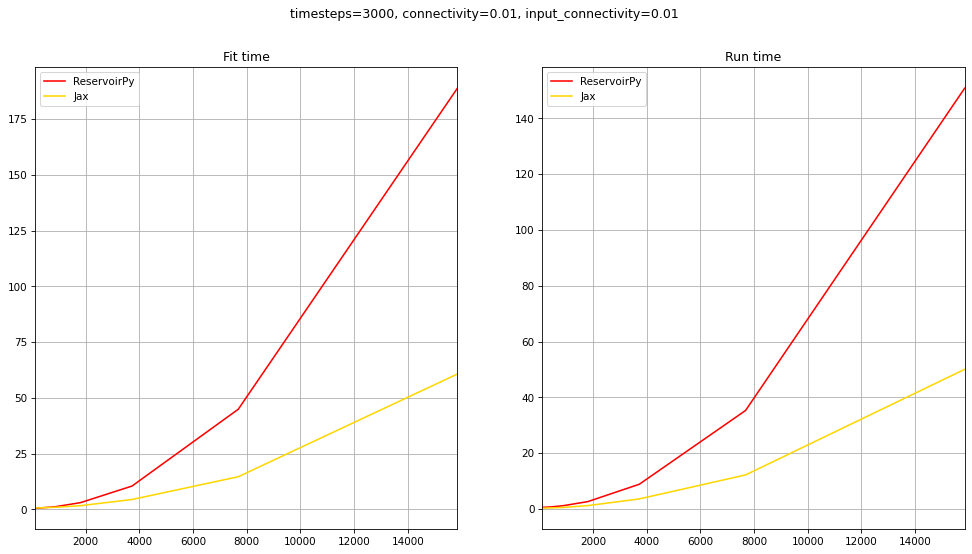

In [6]:
plt.figure(figsize=(16, 8))
plt.suptitle(
    f"timesteps={TIMESTEPS}, connectivity={CONNECTIVITY}, input_connectivity={INPUT_CONNECTIVITY}"
)
plt.subplot(1, 2, 1)
plt.title("Fit time")
plt.plot(unit_trials, fit_times[:, 0], color="red", label="ReservoirPy")
plt.plot(unit_trials, fit_times[:, 1], color="gold", label="Jax")
plt.legend()
plt.grid()
plt.subplot(1, 2, 2)
plt.title("Run time")
plt.plot(unit_trials, run_times[:, 0], color="red", label="ReservoirPy")
plt.plot(unit_trials, run_times[:, 1], color="gold", label="Jax")
plt.legend()
plt.grid()

plt.show()

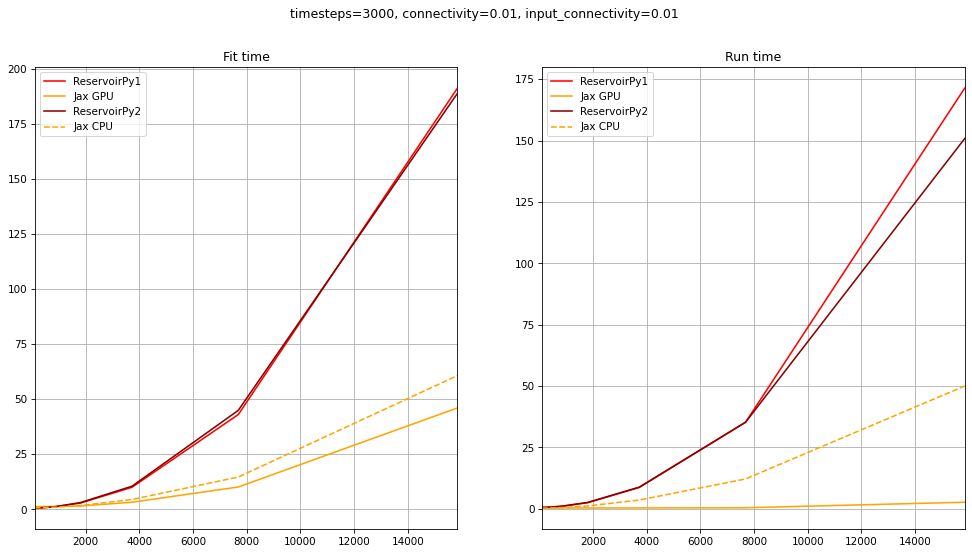

In [13]:
fit_cpu = np.load("fit_times_N_0,01_cpu.npy")[:, 1]
fit_gpu = np.load("fit_times_N.npy")[:, 1]
fit_rpy1 = np.load("fit_times_N.npy")[:, 0]
fit_rpy2 = np.load("fit_times_N_0,01_cpu.npy")[:, 0]

run_cpu = np.load("run_times_N_0,01_cpu.npy")[:, 1]
run_gpu = np.load("run_times_N.npy")[:, 1]
run_rpy1 = np.load("run_times_N.npy")[:, 0]
run_rpy2 = np.load("run_times_N_0,01_cpu.npy")[:, 0]

plt.figure(figsize=(16, 8))
plt.suptitle(
    f"timesteps={TIMESTEPS}, connectivity={CONNECTIVITY}, input_connectivity={INPUT_CONNECTIVITY}"
)
plt.subplot(1, 2, 1)
plt.title("Fit time")
plt.plot(unit_trials, fit_rpy1, color="red", label="ReservoirPy1")
plt.plot(unit_trials, fit_gpu, color="orange", label="Jax GPU")
plt.plot(unit_trials, fit_rpy2, color="#880000", label="ReservoirPy2")
plt.plot(unit_trials, fit_cpu, "--", color="orange", label="Jax CPU")
plt.legend()
plt.grid()
plt.subplot(1, 2, 2)
plt.title("Run time")
plt.plot(unit_trials, run_rpy1, color="red", label="ReservoirPy1")
plt.plot(unit_trials, run_gpu, color="orange", label="Jax GPU")
plt.plot(unit_trials, run_rpy2, color="#880000", label="ReservoirPy2")
plt.plot(unit_trials, run_cpu, "--", color="orange", label="Jax CPU")
plt.legend()
plt.grid()

plt.show()

### Avec compilation de la régression linéaire

100
0.1380307674407959
0.0094451904296875
0.1746664047241211
206
0.14734745025634766
0.11547064781188965
0.17859840393066406
425
0.20050477981567383
0.11973285675048828
0.18104314804077148
876
0.19789433479309082
0.13936066627502441
0.20240235328674316
1807
0.4126923084259033
0.2132549285888672
0.2712132930755615
3727
1.3371617794036865
0.5495650768280029
0.5036861896514893
7686
6.16062593460083
2.323521137237549
1.779783010482788
15848
40.34972858428955
12.903486728668213
9.739870548248291


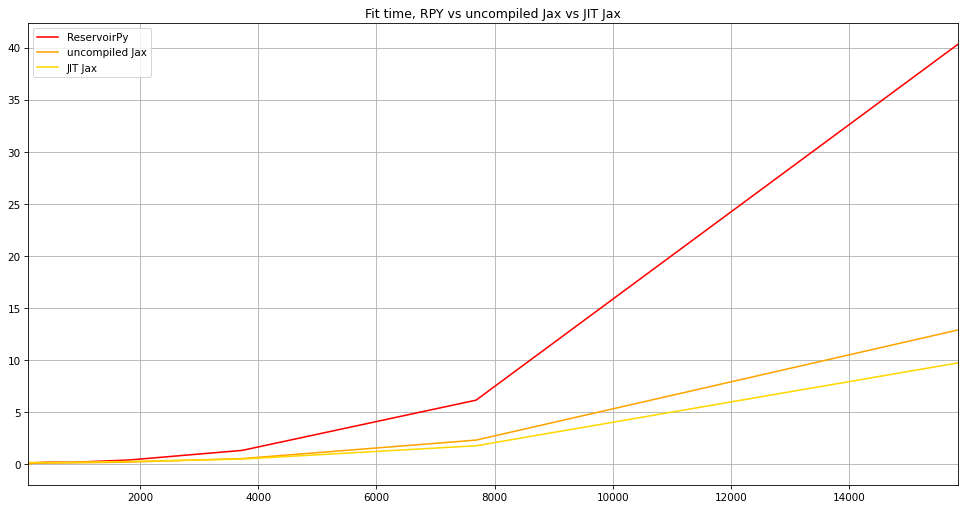

In [7]:
# En fonction de N
unit_trials = np.logspace(2, 4.2, 8).astype(int)
times = np.zeros((8, 3))

for i, units in enumerate(unit_trials):
    print(units)

    X = np.random.normal(size=(TIMESTEPS, units))
    Y = np.random.normal(size=(TIMESTEPS, 1))
    
    ridge_node = rpy.nodes.Ridge(ridge=1,input_bias=False)

    start = time.time()
    ridge_node.fit(X, Y)
    stop = time.time()
    print(stop - start)
    times[i, 0] = stop - start

    start = time.time()
    esn_jax.ESN._ridge_regression(1, X, Y)
    stop = time.time()
    times[i, 1] = stop - start
    print(stop - start)

    start = time.time()
    jax.jit(esn_jax.ESN._ridge_regression)(1, X, Y).block_until_ready()
    stop = time.time()
    times[i, 2] = stop - start
    print(stop - start)

plt.figure(figsize=(16, 8))
plt.title("Fit time, RPY vs uncompiled Jax vs JIT Jax")
plt.plot(unit_trials, times[:, 0], color="red", label="ReservoirPy")
plt.plot(unit_trials, times[:, 1], color="orange", label="uncompiled Jax")
plt.plot(unit_trials, times[:, 2], color="gold", label="JIT Jax")
plt.legend()
plt.grid()

plt.show()

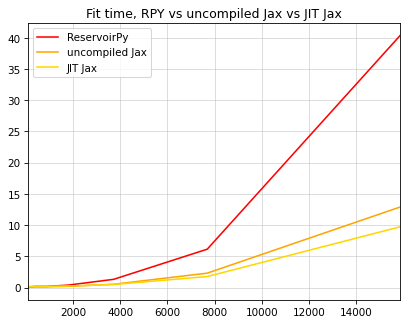

In [8]:

plt.figure()
plt.title("Fit time, RPY vs uncompiled Jax vs JIT Jax")
plt.plot(unit_trials, times[:, 0], color="red", label="ReservoirPy")
plt.plot(unit_trials, times[:, 1], color="orange", label="uncompiled Jax")
plt.plot(unit_trials, times[:, 2], color="gold", label="JIT Jax")
plt.legend()

plt.grid(alpha=0.5)

plt.show()

#### Degré de connectivité

In [9]:
# En fonction de N

unit_trials = np.logspace(2, 4.2, 8).astype(int)
fit_times = np.zeros((8, 2))
run_times = np.zeros((8, 2))

for i, units in enumerate(unit_trials):
    print(units)

    rpy_model = rpy.nodes.ESN(
        units=units,
        connectivity=5/units,
        input_connectivity=5/units,
        ridge=1,
    )
    jax_model = esn_jax.ESN(
        units=units,
        connectivity=5/units,
        input_connectivity=5/units,
        ridge=1,
    )

    start = time.time()
    rpy_model.fit(x, y)
    fit_time = time.time()
    rpy_model.run(x)
    stop = time.time()
    print(stop - start)

    fit_times[i, 0] = fit_time - start
    run_times[i, 0] = stop - fit_time

    start = time.time()
    jax_model.fit(x, y)
    fit_time = time.time()
    jax_model.run(x)
    stop = time.time()
    print(stop - start)

    fit_times[i, 1] = fit_time - start
    run_times[i, 1] = stop - fit_time

np.save("fit_times_N_d3_cpu", fit_times)
np.save("run_times_N_d3_cpu", run_times)

100
1.0772655010223389
0.5292737483978271
206
1.1618010997772217
0.5933892726898193
425
1.4920547008514404
0.6659989356994629
876
2.223308801651001
0.8113093376159668
1807
5.29247784614563
1.1506164073944092
3727
18.88686227798462
2.0170528888702393
7686
77.48317265510559
4.6085405349731445
15848
365.51272678375244
15.664976358413696


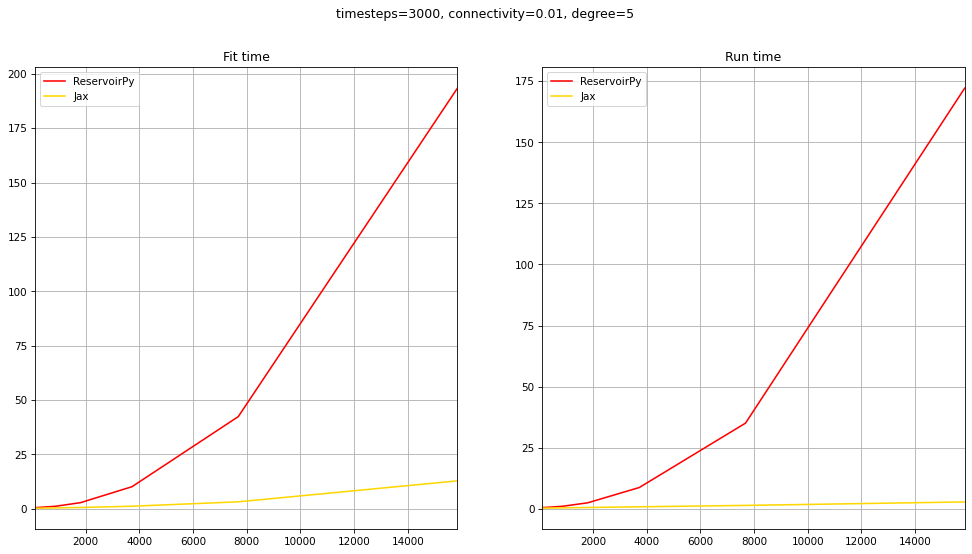

In [10]:

plt.figure(figsize=(16, 8))
plt.suptitle(
    f"timesteps={TIMESTEPS}, connectivity={CONNECTIVITY}, degree={5}"
)
plt.subplot(1, 2, 1)
plt.title("Fit time")
plt.plot(unit_trials, fit_times[:, 0], color="red", label="ReservoirPy")
plt.plot(unit_trials, fit_times[:, 1], color="gold", label="Jax")
plt.grid()
plt.legend()
plt.subplot(1, 2, 2)
plt.title("Run time")
plt.plot(unit_trials, run_times[:, 0], color="red", label="ReservoirPy")
plt.plot(unit_trials, run_times[:, 1], color="gold", label="Jax")
plt.grid()
plt.legend()

plt.show()

# TRÈS GROS RESERVOIRS SPARTI

In [4]:
np.logspace(4, 5.5, 4).astype(int)

array([ 10000,  31622, 100000, 316227])

In [5]:
# En fonction de N

unit_trials = np.logspace(4, 5.5, 4).astype(int)
times = np.zeros((4, ))

for i, units in enumerate(unit_trials):
    print(units)

    jax_model = esn_jax.ESN(
        units=units,
        connectivity=5/units,
        input_connectivity=5/units,
        ridge=1,
    )

    start = time.time()
    jax_model.fit(x, y)
    stop = time.time()
    print(stop - start)

    times[i] = stop - start

np.save("large_reservoirs", times)

10000
17.17892551422119
31622


2024-06-06 14:24:07.049824: W external/tsl/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.72GiB (rounded to 3999803648)requested by op 
2024-06-06 14:24:07.050132: W external/tsl/tsl/framework/bfc_allocator.cc:497] ****__****************************************************************______________________________
2024-06-06 14:24:07.050237: E external/xla/xla/pjrt/pjrt_stream_executor_client.cc:2732] Execution of replica 0 failed: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 3999803536 bytes.
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:    3.72GiB
              constant allocation:         0B
        maybe_live_out allocation:    3.72GiB
     preallocated temp allocation:         0B
                 total allocation:    7.45GiB
              total fragmentation:         0B (0.00%)
Peak buffers:
	Buffer 1:
		Size: 3.72GiB
		Entry Parameter Subshape: s32[31622,31622]

	Buffer 2:

XlaRuntimeError: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 3999803536 bytes.
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:    3.72GiB
              constant allocation:         0B
        maybe_live_out allocation:    3.72GiB
     preallocated temp allocation:         0B
                 total allocation:    7.45GiB
              total fragmentation:         0B (0.00%)
Peak buffers:
	Buffer 1:
		Size: 3.72GiB
		Entry Parameter Subshape: s32[31622,31622]
		==========================

	Buffer 2:
		Size: 3.72GiB
		Operator: op_name="jit(add)/jit(main)/add" source_file="/home/paul/Bureau/reservoir/playground/jax-tests/esn_jax.py" source_line=83
		XLA Label: fusion
		Shape: s32[31622,31622]
		==========================

	Buffer 3:
		Size: 4B
		Entry Parameter Subshape: s32[]
		==========================



In [1]:

import math
import operator

from jax import dtypes
from jax import vmap
from jax import random
from jax.util import split_list
import jax.numpy as jnp
from jax.experimental import sparse

import numpy as np
import jax

def random_bcoo(
  key,
  shape,
  *,
  dtype=jnp.float_,
  indices_dtype=None,
  nse=0.2,
  n_batch=0,
  n_dense=0,
  unique_indices=True,
  sorted_indices=False,
  generator=random.uniform,
  **kwds,
):
  shape = tuple(map(operator.index, shape))
  n_batch = operator.index(n_batch)
  n_dense = operator.index(n_dense)
  if n_batch < 0 or n_dense < 0 or n_batch + n_dense > len(shape):
    raise ValueError(f"Invalid {n_batch=}, {n_dense=} for {shape=}")
  n_sparse = len(shape) - n_batch - n_dense
  batch_shape, sparse_shape, dense_shape = map(
    tuple, split_list(shape, [n_batch, n_sparse])
  )
  print(f"{shape=}, {n_batch=}, {n_sparse=}, batch_shape, sparse_shape, dense_shape: {batch_shape, sparse_shape, dense_shape}")

  batch_size = math.prod(batch_shape)
  sparse_size = math.prod(sparse_shape)
  if not 0 <= nse < sparse_size:
    raise ValueError(f"got {nse=}, expected to be between 0 and {sparse_size}")
  if 0 < nse < 1:
    nse = int(math.ceil(nse * sparse_size))
  nse = operator.index(nse)

  data_shape = batch_shape + (nse,) + dense_shape
  indices_shape = batch_shape + (nse, n_sparse)
  if indices_dtype is None:
    indices_dtype = dtypes.canonicalize_dtype(jnp.int_)
  if sparse_size > jnp.iinfo(indices_dtype).max:
    raise ValueError(
      f"{indices_dtype=} does not have enough range to generate "
      f"sparse indices of size {sparse_size}."
    )
  print(3)

  @vmap
  def _indices(key):
    if not sparse_shape:
      return jnp.empty((nse, n_sparse), dtype=indices_dtype)
    flat_ind = random.choice(
      key, sparse_size, shape=(nse,), replace=not unique_indices
    ).astype(indices_dtype)
    return jnp.column_stack(jnp.unravel_index(flat_ind, sparse_shape))

  keys = random.split(key, batch_size + 1)
  print(4)
  data_key, index_keys = keys[0], keys[1:]
  print(5, data_key, data_shape, dtype, kwds)
  data = generator(data_key, shape=data_shape, dtype=dtype, **kwds)
  print(6)
  indices = _indices(index_keys).reshape(indices_shape)
  print(7)
  mat = sparse.BCOO((data, indices), shape=shape)
  return mat.sort_indices() if sorted_indices else mat

In [9]:
sparse_shape = (31622, 31622)
sparse_size = np.prod(sparse_shape)
nse=100
n_sparse = 2
unique_indices = False

key=jax.random.PRNGKey(seed=1)
keys = random.split(key, 2)

@vmap
def _indices(key):
    if not sparse_shape:
        return jnp.empty((nse, n_sparse), dtype=jnp.float32)
    print("XDDDDDDD")
    flat_ind = random.choice(
        key, sparse_size, shape=(nse,), replace=not unique_indices
    ).astype(dtypes.canonicalize_dtype(jnp.int_))
    print("AAAAAAAA")
    unraveled = jnp.unravel_index(flat_ind, sparse_shape)
    print("EEEEEEEE")
    return jnp.column_stack(unraveled)

_indices(keys)

XDDDDDDD
AAAAAAAA
EEEEEEEE


Array([[[19673,  9032],
        [ 3886, 23808],
        [ 9694, 22193],
        [ 3602,  6541],
        [ 5876, 12215],
        [17943,  4370],
        [29922,  4612],
        [10083,  2915],
        [17238, 29713],
        [ 7715, 30180],
        [24506, 17231],
        [21927, 19445],
        [16431, 12467],
        [11214, 12799],
        [  352,  3436],
        [ 1473, 28417],
        [27845,  3693],
        [  429, 16323],
        [29792, 10990],
        [14678,  2132],
        [15863, 30847],
        [10230, 28146],
        [12934, 25461],
        [ 9560, 22587],
        [19780, 27112],
        [23913, 18894],
        [27471,  5004],
        [ 5407, 30249],
        [23212, 17503],
        [27190, 17959],
        [24695,  3429],
        [10037, 16722],
        [13335, 13257],
        [ 7004, 26681],
        [ 2273, 27933],
        [28681,  2465],
        [ 3711, 28887],
        [11190, 29315],
        [20900, 24327],
        [21919, 20306],
        [18800,  3607],
        [25624, 

In [5]:
import os

os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"]="false"

In [15]:
import jax
import os
from jax.experimental import sparse
import numpy as np

W = random_bcoo(
    key=jax.random.PRNGKey(seed=1),
    shape=(31622, 31622),
    dtype=np.float32,
    indices_dtype=int,
    nse=100,
    n_batch=0,
    n_dense=0,
    unique_indices=False,
    generator=jax.random.normal,
)

shape=(31622, 31622), n_batch=0, n_sparse=2, batch_shape, sparse_shape, dense_shape: ((), (31622, 31622), ())
3
4
5 [2441914641 1384938218] (100,) <class 'numpy.float32'> {}
6
7


In [3]:
import jax
import os
from jax.experimental import sparse
import numpy as np

os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"]="false"
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]=".25"
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"]="platform"


@jax.jit
def test(a):
    W = a*sparse.random_bcoo(
        key=jax.random.PRNGKey(seed=1),
        shape=(31622, 31622),
        dtype=np.float32,
        indices_dtype=int,
        nse=0.001,
        generator=jax.random.normal,
    )
    Win = sparse.random_bcoo(
        key=jax.random.PRNGKey(seed=1),
        shape=(1, 31622),
        dtype=np.float32,
        indices_dtype=int,
        nse=0.001,
        generator=jax.random.normal,
    )
    return 1. * Win * W * Win.T

test(2.)

2024-06-05 16:37:42.222492: E external/xla/xla/pjrt/pjrt_stream_executor_client.cc:2732] Execution of replica 0 failed: RESOURCE_EXHAUSTED: Failed to allocate request for 7.63GiB (8191598592B) on device ordinal 0
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:         4B
              constant allocation:        20B
        maybe_live_out allocation:   11.44GiB
     preallocated temp allocation:   14.90GiB
  preallocated temp fragmentation:       912B (0.00%)
                 total allocation:   26.34GiB
              total fragmentation:    3.99GiB (15.16%)
Peak buffers:
	Buffer 1:
		Size: 7.63GiB
		Operator: op_name="jit(test)/jit(main)/max" source_file="/tmp/ipykernel_39556/1552486716.py" source_line=29
		XLA Label: fusion
		Shape: s32[1,1023949824,2]

	Buffer 2:
		Size: 3.81GiB
		Operator: op_name="jit(test)/jit(main)/mul" source_file="/tmp/ipykernel_39556/1552486716.py" source_line=29
		XLA Label: fusion
		Shape: f32[1023949824,1]

	Buffe

XlaRuntimeError: RESOURCE_EXHAUSTED: Failed to allocate request for 7.63GiB (8191598592B) on device ordinal 0
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:         4B
              constant allocation:        20B
        maybe_live_out allocation:   11.44GiB
     preallocated temp allocation:   14.90GiB
  preallocated temp fragmentation:       912B (0.00%)
                 total allocation:   26.34GiB
              total fragmentation:    3.99GiB (15.16%)
Peak buffers:
	Buffer 1:
		Size: 7.63GiB
		Operator: op_name="jit(test)/jit(main)/max" source_file="/tmp/ipykernel_39556/1552486716.py" source_line=29
		XLA Label: fusion
		Shape: s32[1,1023949824,2]
		==========================

	Buffer 2:
		Size: 3.81GiB
		Operator: op_name="jit(test)/jit(main)/mul" source_file="/tmp/ipykernel_39556/1552486716.py" source_line=29
		XLA Label: fusion
		Shape: f32[1023949824,1]
		==========================

	Buffer 3:
		Size: 3.72GiB
		Operator: op_name="jit(test)/jit(main)/vmap(jit(_shuffle))/sort[dimension=1 is_stable=True num_keys=1]" source_file="/tmp/ipykernel_39556/1341197815.py" source_line=10
		XLA Label: sort
		Shape: s32[1,999950884]
		==========================

	Buffer 4:
		Size: 3.72GiB
		Operator: op_name="jit(test)/jit(main)/vmap(jit(_shuffle))/sort[dimension=1 is_stable=True num_keys=1]" source_file="/tmp/ipykernel_39556/1341197815.py" source_line=10
		XLA Label: sort
		Shape: s32[1,999950884]
		==========================

	Buffer 5:
		Size: 3.72GiB
		Operator: op_name="jit(test)/jit(main)/iota[dtype=int32 shape=(999950884,) dimension=0]" source_file="/tmp/ipykernel_39556/1552486716.py" source_line=13
		XLA Label: fusion
		Shape: s32[1,999950884]
		==========================

	Buffer 6:
		Size: 1.86GiB
		Operator: op_name="jit(test)/jit(main)/vmap(jit(_shuffle))/slice[start_indices=(499975442,) limit_indices=(999950884,) strides=None]" source_file="/tmp/ipykernel_39556/1341197815.py" source_line=10
		XLA Label: fusion
		Shape: u32[499975442]
		==========================

	Buffer 7:
		Size: 1.86GiB
		Operator: op_name="jit(test)/jit(main)/vmap(jit(_shuffle))/slice[start_indices=(0,) limit_indices=(499975442,) strides=None]" source_file="/tmp/ipykernel_39556/1341197815.py" source_line=10
		XLA Label: fusion
		Shape: u32[499975442]
		==========================

	Buffer 8:
		Size: 24B
		Operator: op_name="jit(test)/jit(main)/vmap(jit(_shuffle))/sort[dimension=1 is_stable=True num_keys=1]" source_file="/tmp/ipykernel_39556/1341197815.py" source_line=10
		XLA Label: sort
		Shape: (u32[1,999950884], s32[1,999950884], s32[1,999950884])
		==========================

	Buffer 9:
		Size: 24B
		Operator: op_name="jit(test)/jit(main)/vmap(jit(_shuffle))/sort[dimension=1 is_stable=True num_keys=1]" source_file="/tmp/ipykernel_39556/1552486716.py" source_line=21
		XLA Label: sort
		Shape: (u32[1,31622], s32[1,31622], s32[1,31622])
		==========================

	Buffer 10:
		Size: 24B
		Operator: op_name="jit(test)/jit(main)/vmap(jit(_shuffle))/sort[dimension=1 is_stable=True num_keys=1]" source_file="/tmp/ipykernel_39556/1552486716.py" source_line=21
		XLA Label: sort
		Shape: (u32[1,31622], s32[1,31622], s32[1,31622])
		==========================

	Buffer 11:
		Size: 24B
		Operator: op_name="jit(test)/jit(main)/and" source_file="/tmp/ipykernel_39556/1552486716.py" source_line=29
		XLA Label: fusion
		Shape: (pred[31998432,1], s32[31998432], pred[31998432,1])
		==========================

	Buffer 12:
		Size: 24B
		Operator: op_name="jit(test)/jit(main)/and" source_file="/tmp/ipykernel_39556/1552486716.py" source_line=29
		XLA Label: fusion
		Shape: (pred[31998432,1], s32[31998432], pred[31998432,1])
		==========================

	Buffer 13:
		Size: 24B
		Operator: op_name="jit(test)/jit(main)/and" source_file="/tmp/ipykernel_39556/1552486716.py" source_line=29
		XLA Label: fusion
		Shape: (pred[31998432,1], s32[31998432], pred[31998432,1])
		==========================

	Buffer 14:
		Size: 24B
		Operator: op_name="jit(test)/jit(main)/mul" source_file="/tmp/ipykernel_39556/1552486716.py" source_line=29
		XLA Label: fusion
		Shape: (f32[1023949824,1], pred[1023949824,1], pred[1023949824,1])
		==========================

	Buffer 15:
		Size: 24B
		Operator: op_name="jit(test)/jit(main)/and" source_file="/tmp/ipykernel_39556/1552486716.py" source_line=29
		XLA Label: fusion
		Shape: (pred[31998432,1], s32[31998432], pred[31998432,1])
		==========================

